In [3]:
import pandas as pd
from sqlalchemy import create_engine, text
import urllib

# DB credentials
server = 'qaececrm-s1.database.windows.net'  
database = 'QAECECRM_June2025'
username = 'dbadmin'
password = 'DashTech1234'
driver = 'ODBC Driver 17 for SQL Server'

# Connection string
params = urllib.parse.quote_plus(
    f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

In [4]:
# 1. Force full display
pd.set_option('display.max_rows',    None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width',       None)
pd.set_option('display.max_colwidth', None)

In [5]:
pip install pandas sqlalchemy pyodbc

Note: you may need to restart the kernel to use updated packages.


In [6]:
def query_db(engine, query):
    with engine.connect() as conn:
        result = pd.read_sql(query, conn)
    return result

In [7]:
query = text("""
WITH agent AS (
    SELECT AgentId, ContractId, ContractTransactionId 
    FROM [dbo].[AgentPayrollLog]
),
tx_cost AS (
    SELECT ct.ContractId,
           at.AgentId,
           SUM(CASE WHEN IsExpense = 1 THEN PaidAmount ELSE 0 END) AS TotalPaidOut,
           SUM(CASE WHEN IsExpense = 0 THEN PaidAmount ELSE 0 END) AS CreditsReceived
    FROM ContractTransaction ct
    JOIN agent at ON (ct.ContractId = at.ContractId) AND (ct.ContractTransactionId = at.ContractTransactionId)
    GROUP BY ct.ContractId, at.AgentId
),
dep AS (
    SELECT ContractId,
           SUM(AppliedAmount) AS TotalDeposits,      
           SUM(CASE WHEN IsDeleted = 0 THEN AppliedAmount ELSE 0 END) AS DepositsReceived
    FROM ContractDeposit
    GROUP BY ContractId
),
artist AS (
    SELECT 
        ContractId, 
        STRING_AGG(ArtistName, ', ') AS artistname
    FROM [dbo].[ContractArtist]
    GROUP BY ContractId
),
term_count AS (
    SELECT ContractId, COUNT(*) AS no_of_terms 
    FROM [dbo].[ContractTerm] 
    WHERE IsActive = 1
    GROUP BY ContractId
)
SELECT
    c.Gross AS GrossContractAmount,
    tx_cost.AgentId AS Agent,
    artistname AS List_of_Artist,
    c.VenueName AS Venue_Name,
    LOWER(c.VenuePhysicalCity) AS Venue_city,
    c.LineOfBusinessId AS LOB,
    COALESCE(term_count.no_of_terms, 1) AS Terms,
    COALESCE(tx_cost.CreditsReceived, 0) AS CreditsReceived,
    COALESCE(tx_cost.TotalPaidOut, 0) AS TotalPaidOut,
    COALESCE(dep.DepositsReceived, 0) AS DepositsReceived,
    COALESCE(tx_cost.CreditsReceived, 0)
    + COALESCE(dep.DepositsReceived, 0)
    - COALESCE(tx_cost.TotalPaidOut, 0) AS NetProfitLoss,
    CASE
        WHEN (
            COALESCE(tx_cost.CreditsReceived, 0)
          + COALESCE(dep.DepositsReceived, 0)
          - COALESCE(tx_cost.TotalPaidOut, 0)
        ) > 0 THEN 'Profit'
        WHEN (
            COALESCE(tx_cost.CreditsReceived, 0)
          + COALESCE(dep.DepositsReceived, 0)
          - COALESCE(tx_cost.TotalPaidOut, 0)
        ) < 0 THEN 'Loss'
        ELSE 'Break-Even'
    END AS ProfitLossStatus
FROM Contract c
LEFT JOIN tx_cost ON tx_cost.ContractId = c.ContractId
LEFT JOIN dep ON dep.ContractId = c.ContractId
LEFT JOIN artist ON artist.ContractId = c.ContractId
LEFT JOIN term_count ON term_count.ContractId = c.ContractId
ORDER BY NetProfitLoss ASC;
""")

In [8]:
JoinedData = query_db(engine, query)

In [10]:
JoinedData.head()

,GrossContractAmount,Agent,List_of_Artist,Venue_Name,Venue_city,LOB,Terms,CreditsReceived,TotalPaidOut,DepositsReceived,NetProfitLoss,ProfitLossStatus
0,194500.0,413.0,THE B-52'S,"HANGER DECK, THE INTREPID MUSEUM",new york,3.0,1,0.0,35470.44,0.0,-35470.44,Loss
1,29000.0,386.0,EASTCOAST EVENTS,CHECCA LODGE,islamorada,3.0,1,0.0,29000.00,0.0,-29000.00,Loss
2,55000.0,413.0,THE SPINNERS,THE MUSEUM OF NATURAL HISTORY,new york,3.0,1,0.0,21341.52,0.0,-21341.52,Loss
3,95000.0,397.0,K.C. & THE SUNSHINE BAND,MEMORIAL HALL,philadelphia,1.0,1,0.0,20171.62,0.0,-20171.62,Loss
4,22000.0,307.0,KOOL & THE GANG ECE PROCUREMENT,ITT SHERATON,ethiopia,1.0,1,0.0,18985.69,0.0,-18985.69,Loss


In [11]:
JoinedData['ProfitLossStatus'].value_counts()

ProfitLossStatus
Profit        237606
Break-Even     85233
Loss            2793
Name: count, dtype: int64

In [12]:
import pandas as pd
import numpy as np

# Create Profit Margin (handle divide by zero)
JoinedData['ProfitMargin'] = JoinedData.apply(
    lambda row: row['NetProfitLoss'] / row['GrossContractAmount'] 
                if row['GrossContractAmount'] != 0 else 0, axis=1)

# Binary Loss Indicator
JoinedData['IsLoss'] = JoinedData['ProfitLossStatus'].apply(lambda x: 1 if x == 'Loss' else 0)

# High-value contract flag (example threshold: 1 million)
JoinedData['IsHighValueContract'] = JoinedData['GrossContractAmount'] > 1_000_000

# Credit to cost ratio (avoid divide by zero)
JoinedData['CreditToCostRatio'] = JoinedData.apply(
    lambda row: row['CreditsReceived'] / (row['TotalPaidOut'] + 1), axis=1)

# Agent's average profit and number of contracts
agent_stats = JoinedData.groupby('Agent')['NetProfitLoss'].agg(['mean', 'count']).reset_index()
agent_stats.columns = ['Agent', 'AgentAvgProfit', 'AgentContractCount']

# Merge back to main dataframe
JoinedData = JoinedData.merge(agent_stats, on='Agent', how='left')

In [13]:
print(JoinedData.shape)
print(JoinedData.head())

# Or display a sample
JoinedData.sample(5)

(325632, 18)
   GrossContractAmount  Agent                   List_of_Artist  \
0             194500.0  413.0                       THE B-52'S   
1              29000.0  386.0                 EASTCOAST EVENTS   
2              55000.0  413.0                     THE SPINNERS   
3              95000.0  397.0         K.C. & THE SUNSHINE BAND   
4              22000.0  307.0  KOOL & THE GANG ECE PROCUREMENT   

                         Venue_Name    Venue_city  LOB  Terms  \
0  HANGER DECK, THE INTREPID MUSEUM      new york  3.0      1   
1                      CHECCA LODGE    islamorada  3.0      1   
2     THE MUSEUM OF NATURAL HISTORY      new york  3.0      1   
3                     MEMORIAL HALL  philadelphia  1.0      1   
4                      ITT SHERATON      ethiopia  1.0      1   

   CreditsReceived  TotalPaidOut  DepositsReceived  NetProfitLoss  \
0              0.0      35470.44               0.0      -35470.44   
1              0.0      29000.00               0.0      -2900

,GrossContractAmount,Agent,List_of_Artist,Venue_Name,Venue_city,LOB,Terms,CreditsReceived,TotalPaidOut,DepositsReceived,NetProfitLoss,ProfitLossStatus,ProfitMargin,IsLoss,IsHighValueContract,CreditToCostRatio,AgentAvgProfit,AgentContractCount
149701,2300.0,471.0,BLACK & BLUE,ELK RIVER COUNTRY CLUB,banner elk,3.0,3,0.0,460.0,800.0,340.0,Profit,0.147826,0,False,0.0,806.703824,6598.0
311050,17000.0,435.0,PERFECT 10 BAND,BELMOND CHARLESTON PLACE,charleston,3.0,1,0.0,3400.0,8500.0,5100.0,Profit,0.300000,0,False,0.0,3399.283202,2111.0
262004,5500.0,330.0,THE MEN OF DISTINCTION,1208 WASHINGTON PLACE,columbia,3.0,3,0.0,1100.0,2750.0,1650.0,Profit,0.300000,0,False,0.0,1248.279375,7443.0
11735,500.0,125.0,BURKE,ADVENTURES UNLIMITED (800-662-0667),ocoee,3.0,1,0.0,100.0,100.0,0.0,Break-Even,0.000000,0,False,0.0,1005.517904,12221.0
256636,3000.0,NaN,RISSE,CAMBERLEY BROWN HOTEL,louisville,3.0,1,0.0,0.0,1500.0,1500.0,Profit,0.500000,0,False,0.0,NaN,NaN


In [14]:
JoinedData['Agent'] = JoinedData['Agent'].fillna(-1)  # or 0 if you prefer
JoinedData['AgentAvgProfit'] = JoinedData['AgentAvgProfit'].fillna(0)
JoinedData['AgentContractCount'] = JoinedData['AgentContractCount'].fillna(0)

In [15]:
JoinedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325632 entries, 0 to 325631
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   GrossContractAmount  325632 non-null  float64
 1   Agent                325632 non-null  float64
 2   List_of_Artist       322529 non-null  object 
 3   Venue_Name           325632 non-null  object 
 4   Venue_city           325632 non-null  object 
 5   LOB                  323889 non-null  float64
 6   Terms                325632 non-null  int64  
 7   CreditsReceived      325632 non-null  float64
 8   TotalPaidOut         325632 non-null  float64
 9   DepositsReceived     325632 non-null  float64
 10  NetProfitLoss        325632 non-null  float64
 11  ProfitLossStatus     325632 non-null  object 
 12  ProfitMargin         325632 non-null  float64
 13  IsLoss               325632 non-null  int64  
 14  IsHighValueContract  325632 non-null  bool   
 15  CreditToCostRatio

In [16]:
JoinedData.sample(5)

,GrossContractAmount,Agent,List_of_Artist,Venue_Name,Venue_city,LOB,Terms,CreditsReceived,TotalPaidOut,DepositsReceived,NetProfitLoss,ProfitLossStatus,ProfitMargin,IsLoss,IsHighValueContract,CreditToCostRatio,AgentAvgProfit,AgentContractCount
120448,550.0,313.0,LES JOLIE DEUX,DOVER HALL,manakin-sabot,3.0,1,0.0,100.0,275.0,175.0,Profit,0.318182,0,False,0.0,1859.612876,6002.0
73871,1000.0,-1.0,THE CALVIN TAYLOR BAND,RADISSON HOTEL,charleston,3.0,1,0.0,0.0,0.0,0.0,Break-Even,0.000000,0,False,0.0,0.000000,0.0
179891,1850.0,125.0,MYSTIC VIBRATIONS REGGAE BAND,The Mullet Festival,swansboro,3.0,1,0.0,350.0,925.0,575.0,Profit,0.310811,0,False,0.0,1005.517904,12221.0
36779,1750.0,-1.0,THE MIKE LATHAM BAND,LONGBRANCH,raleigh,3.0,1,0.0,0.0,0.0,0.0,Break-Even,0.000000,0,False,0.0,0.000000,0.0
302332,11750.0,309.0,LIQUID PLEASURE WITH KENNY MANN,Charlotte Country Club,charlotte,3.0,3,0.0,2150.0,5875.0,3725.0,Profit,0.317021,0,False,0.0,4736.586305,1613.0


In [18]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 130.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


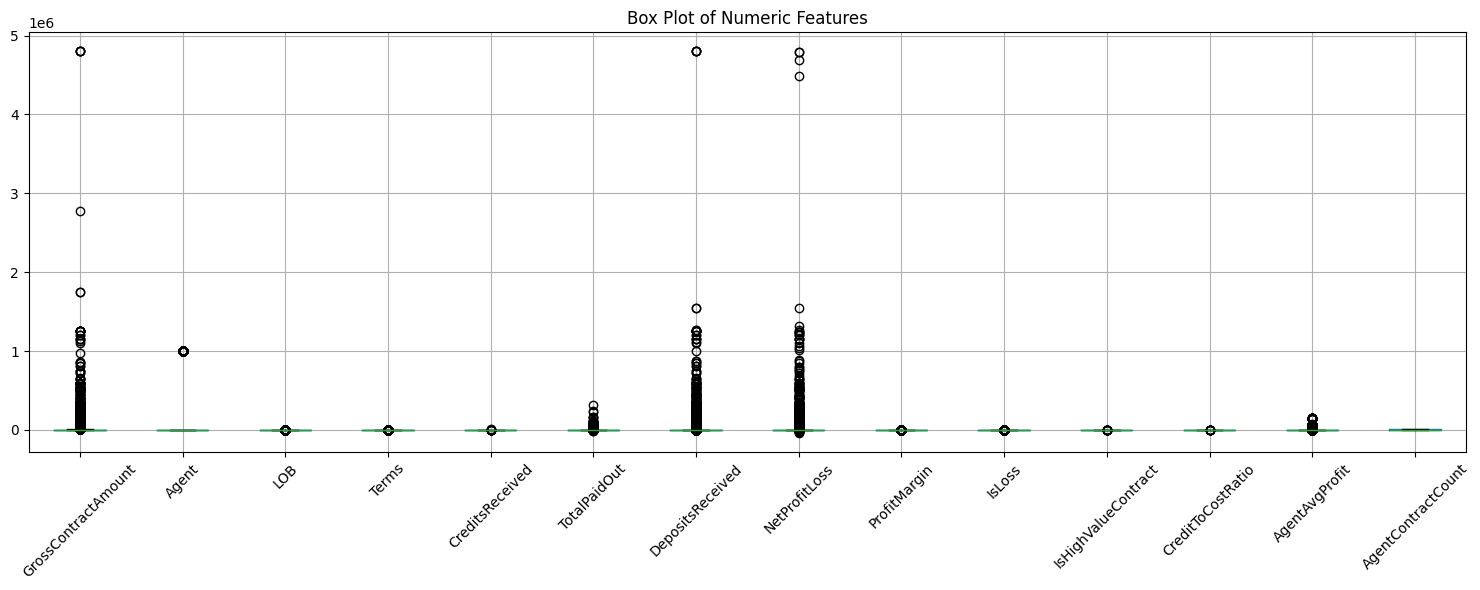

In [19]:
import matplotlib.pyplot as plt

JoinedData.boxplot(figsize=(15, 6))
plt.title("Box Plot of Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
lower = JoinedData['GrossContractAmount'].quantile(0.05)
upper = JoinedData['GrossContractAmount'].quantile(0.95)

filtered_df = JoinedData[(JoinedData['GrossContractAmount'] >= lower) & (JoinedData['GrossContractAmount'] <= upper)]

In [21]:
agent_lower = filtered_df['Agent'].quantile(0.05)
agent_upper = filtered_df['Agent'].quantile(0.95)

filtered_df = filtered_df[(filtered_df['Agent'] >= agent_lower) & (filtered_df['Agent'] <= agent_upper)]

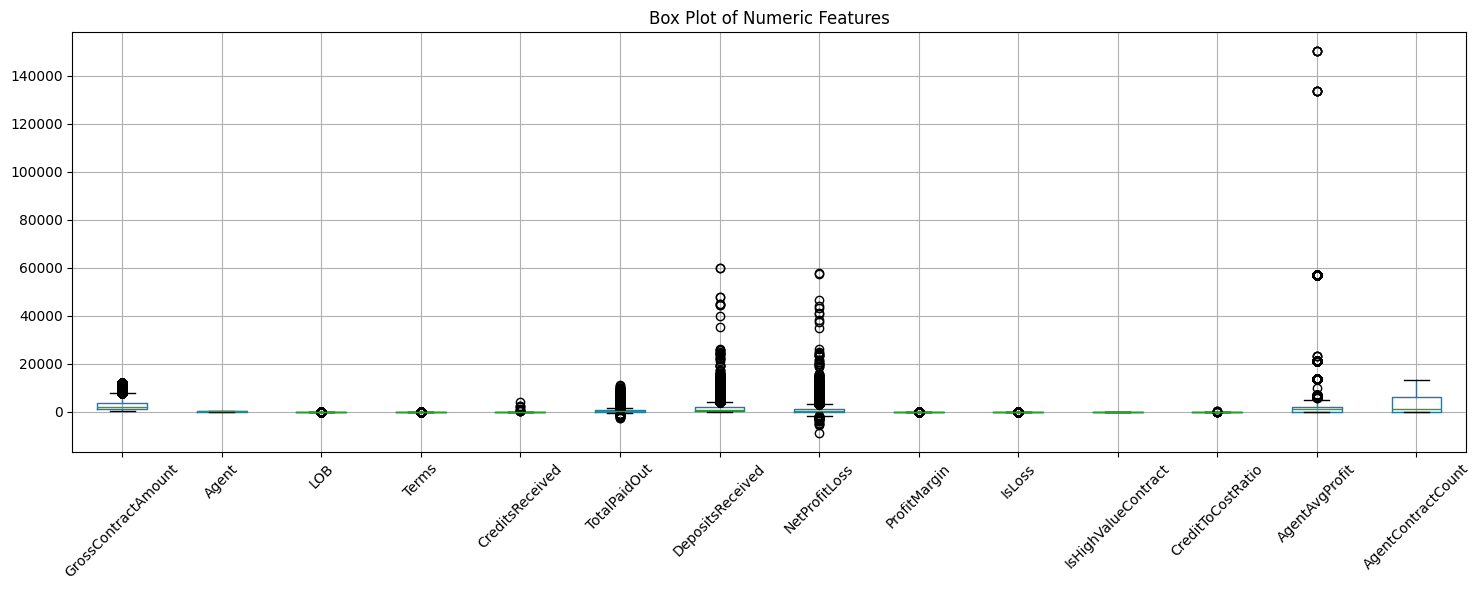

In [22]:
import matplotlib.pyplot as plt

filtered_df.boxplot(figsize=(15, 6))
plt.title("Box Plot of Numeric Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
features = [
    'GrossContractAmount', 'CreditsReceived', 'TotalPaidOut', 'DepositsReceived',
    'ProfitMargin', 'IsHighValueContract', 'CreditToCostRatio',
    'AgentAvgProfit', 'AgentContractCount'
]
X = JoinedData[features].fillna(0)
y = JoinedData['IsLoss']

In [25]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 89.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Aggregate historical average profit per contract for each agent
agent_profit = filtered_df.groupby('Agent').agg({
    'NetProfitLoss': 'mean',
    'GrossContractAmount': 'mean',
    'CreditsReceived': 'mean',
    'TotalPaidOut': 'mean',
    'DepositsReceived': 'mean',
    'AgentContractCount': 'first'  # count is constant per agent
}).reset_index()

agent_profit.rename(columns={'NetProfitLoss': 'AvgProfit'}, inplace=True)

# Fill missing agents (-1) or NaNs if any
agent_profit = agent_profit.fillna(0)

In [27]:
features = ['GrossContractAmount', 'CreditsReceived', 'TotalPaidOut', 'DepositsReceived', 'AgentContractCount']
target = 'AvgProfit'

X = agent_profit[features]
y = agent_profit[target]


In [28]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))


# Print results
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R² Score:", r2)
print("Adjusted R² Score:", adjusted_r2)

Test RMSE: 181.80113751626965
Test MAE: 113.3966043637459
Test R² Score: 0.9124194417877189
Adjusted R² Score: 0.8933801900024404


In [29]:
X_all = filtered_df[features]  # replace with your actual features used in model

filtered_df['PredictedProfit'] = model.predict(X_all)

In [2]:
filtered_df.sample(10)

NameError: name 'filtered_df' is not defined

In [31]:
# Group by Agent and summarize predictions
agent_summary = filtered_df.groupby('Agent').agg(
    TotalPredictedProfit=('PredictedProfit', 'sum'),
    AveragePredictedProfit=('PredictedProfit', 'mean'),
    NumberOfContracts=('PredictedProfit', 'count')
).reset_index()

# Sort to find top agents
top_agents = agent_summary.sort_values(by='TotalPredictedProfit', ascending=False).head(10)

print(top_agents)

     Agent  TotalPredictedProfit  AveragePredictedProfit  NumberOfContracts
0     -1.0          5.208112e+07              440.022983             118360
129  430.0          1.183200e+07             1312.333476               9016
121  417.0          1.173114e+07             1004.550250              11678
11   125.0          1.113537e+07              943.995008              11796
84   330.0          8.975029e+06             1242.390471               7224
57   253.0          8.935180e+06             1603.010383               5574
77   313.0          8.165792e+06             1473.703684               5541
74   307.0          7.061024e+06              885.950371               7970
39   203.0          5.844285e+06             1315.095530               4444
61   270.0          5.503124e+06              944.093940               5829


In [32]:
filtered = filtered_df[filtered_df['Agent'].notnull() & (filtered_df['Agent'] != -1)]

agent_summary = filtered.groupby('Agent').agg(
    TotalPredictedProfit=('PredictedProfit', 'sum'),
    AveragePredictedProfit=('PredictedProfit', 'mean'),
    NumberOfContracts=('PredictedProfit', 'count')
).reset_index()


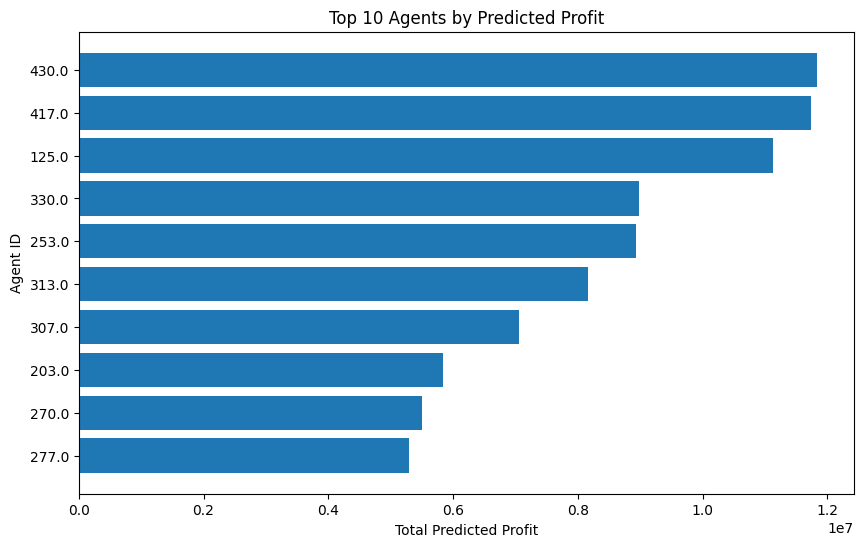

In [33]:
import matplotlib.pyplot as plt

top = agent_summary.sort_values(by='TotalPredictedProfit', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top['Agent'].astype(str), top['TotalPredictedProfit'])
plt.xlabel("Total Predicted Profit")
plt.ylabel("Agent ID")
plt.title("Top 10 Agents by Predicted Profit")
plt.gca().invert_yaxis()
plt.show()

In [34]:
agent_total_profit = filtered_df.groupby('Agent')['PredictedProfit'].sum().reset_index()

# Top 10 agents
top_agents = agent_total_profit.sort_values(by='PredictedProfit', ascending=False).head(10)
top_agent_ids = top_agents['Agent'].tolist()


In [35]:
top_agents_data = filtered_df[filtered_df['Agent'].isin(top_agent_ids)]

In [36]:
# Group by Agent and Venue to calculate total predicted profit
agent_venue_profit = top_agents_data.groupby(['Agent', 'Venue_Name'])['PredictedProfit'].sum().reset_index()

# Sort by profit within each agent and get top venue per agent
top_venue_per_agent = agent_venue_profit.sort_values(['Agent', 'PredictedProfit'], ascending=[True, False])
top_venue_per_agent = top_venue_per_agent.groupby('Agent').first().reset_index()


In [37]:
print(top_venue_per_agent)

   Agent                                  Venue_Name  PredictedProfit
0   -1.0                                         TBA    673780.469569
1  125.0                                CAROLINA INN    320931.658167
2  203.0  GROVE PARK INN & COUNTRY CLUB - GREAT HALL    398337.609385
3  253.0                     FARMINGTON COUNTRY CLUB    167396.936650
4  270.0                                 CAROLINA CC    143743.296224
5  307.0                      CHARLOTTE COUNTRY CLUB    270098.191419
6  313.0                                   [Unknown]    413670.711870
7  330.0                               POINSETT CLUB    299137.441638
8  417.0                     SIGMA PHI EPSILON HOUSE    103133.012440
9  430.0                         CAROLINA YACHT CLUB    314222.468814


In [38]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [40]:
import joblib
joblib.dump(model, "output/model.pkl")

['output/model.pkl']